<center><h2>ALTeGraD 2022<br>Lab Session 2: Transfer learning for NLP</h2> 27 / 10 / 2022<br> M. Kamal Eddine, H. Abdine<br><br>


<b>Student name:</b> GALAGAIN Calvin

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>
 
<b>The deadline for this lab is November 14, 2022 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [ ]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        ### fill me, nhid = the dim_embed
        # ===========================
        self.encoder = nn.Embedding(ntoken, nhid) 
        # ===========================

        ### fill me, the PositionalEncoding class is implemented in the next cell
        # ===========================
        self.pos_encoder = PositionalEncoding(nhid, dropout) 
        # ===========================

        ### fill me we assume nhid = d_model = dim_feedforward
        # ===========================
        encoder_layers = nn.TransformerEncoderLayer(nhid, nhead, nhid, dropout) 
        # ===========================

        ### fill me
        # ===========================
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) 
        # ===========================
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid) 
        ### fill me
        # ===========================
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        # ===========================
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        
        ### fill me
        # ===========================
        self.decoder = nn.Linear(nhid, nclasses)
        # ===========================
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output
    
class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead(nhid, nclasses) 

    def forward(self, src, src_mask):
        ### fill me
        # ===========================
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        # ===========================
        return output

In [ ]:
# explanation of src_mask

model = nn.Transformer()
original_mask = model.generate_square_subsequent_mask(3)
print(original_mask)

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])


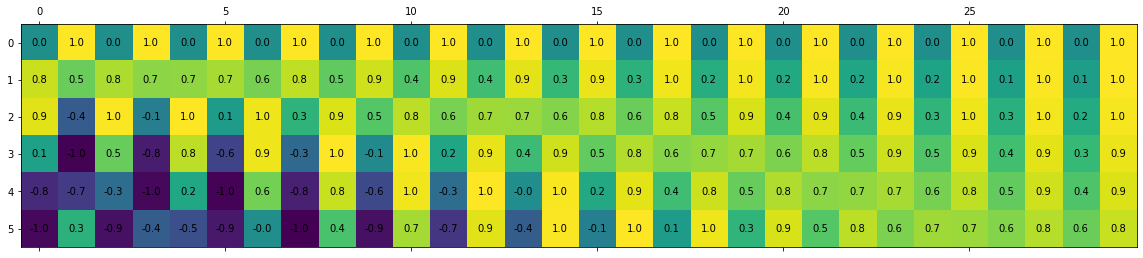

In [ ]:
# explanation of positional encoding
import matplotlib.pyplot as plt
import numpy as np

def positional_encoding(sentence_len, dimension_embedding, n):
    P = np.zeros((sentence_len, dimension_embedding))
    for k in range(sentence_len):
        for i in np.arange(int(dimension_embedding/2)):
            denominator = np.power(n, 2*i/dimension_embedding)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

# for this sentence, we can calcultate the positional encoding
sentence = "Altegrad is the best NLP course."

# and we can plot the result
fig, ax = plt.subplots(figsize=(20, 10))
P = positional_encoding(sentence_len=len(sentence.split(" ")), dimension_embedding=30, n=10)
ax.matshow(P)
for (i, j), z in np.ndenumerate(P):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [ ]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


In [ ]:
# we can also count the number of parameters
all_param = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        # print(name, param.data.shape)
        temp = 1
        for i in param.data.shape:
          temp*=i
        all_param += temp
all_param

1008100

## Vocabulary and Tokenization

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2022-11-14 06:28:56--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>] 564.05K  --.-KB/s    in 0.003s  

2022-11-14 06:28:56 (186 MB/s) - ‘dict.txt’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [ ]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        
        ### fill me
        # ===========================
        token2ind[word] =  idx+4

ind2token = {value:key for key, value in token2ind.items()}
# ===========================

print(ind2token[1111])

▁trop


### Data Loader


In [ ]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        
        ### fill me (constract the input sequence using token2ind, sequence and special tokens)
        # ===========================
        source_sequence = [self.token2ind['<sos>']] 
        
        for word in sequence:
            if word not in self.token2ind:
              source_sequence.append(self.token2ind['<oov>'])
            else:
              source_sequence.append(self.token2ind[word])
        # ===========================
        
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [ ]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    
    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            ### fill me
            # ===========================
            output = output[-1, :]
            # ===========================
        output = output.view(-1, output.shape[-1])

        ### fill me
        # ===========================
        target =  data[1]
        # ===========================
        target = target.to(device)

        ### fill me, Cross entropy check next cells
        # ===========================
        loss = criterion(output, target)
        # ===========================

        ### fill me step 3
        # ===========================
        # prevent exploding gradient
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  
        # ===========================

        ### fill me step 4
        # ===========================
        optimizer.step()
        # ===========================

        total_loss += loss.item() 
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [ ]:
### fill me # the size of vocabulary
# ===========================
ntokens = len(ind2token)
# ===========================

nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [ ]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2022-11-14 06:28:58--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.06s   

2022-11-14 06:28:59 (159 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [ ]:
# pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        ### fill me
        # ===========================
        task="language_modeling",
        # ===========================
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.31476 | ppl 1502.307
| epoch   1 |  1000/ 3125 steps | loss 6.47886 | ppl  651.227
| epoch   1 |  1500/ 3125 steps | loss 6.20463 | ppl  495.035
| epoch   1 |  2000/ 3125 steps | loss 6.04726 | ppl  422.954
| epoch   1 |  2500/ 3125 steps | loss 5.92711 | ppl  375.068
| epoch   1 |  3000/ 3125 steps | loss 5.83857 | ppl  343.287
| epoch   2 |   500/ 3125 steps | loss 5.49464 | ppl  243.385
| epoch   2 |  1000/ 3125 steps | loss 5.46212 | ppl  235.596
| epoch   2 |  1500/ 3125 steps | loss 5.45140 | ppl  233.084
| epoch   2 |  2000/ 3125 steps | loss 5.40564 | ppl  222.658
| epoch   2 |  2500/ 3125 steps | loss 5.38080 | ppl  217.197
| epoch   2 |  3000/ 3125 steps | loss 5.37182 | ppl  215.254


## Text Generation


In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device) 

#load the checkpoint
# checkpoint = torch.load('pretrained_model_4layers.pt') 
checkpoint = torch.load('pretrained_model_4layers.pt', map_location=torch.device('cpu')) 

#load state dict
model.load_state_dict(checkpoint['model_state_dict']) 

--2022-11-14 06:34:00--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt’

pretrained_model_4l 100%[===================>]  84.01M   350MB/s    in 0.2s    

2022-11-14 06:34:09 (350 MB/s) - ‘pretrained_model_4layers.pt’ saved [88093955/88093955]



<All keys matched successfully>

In [ ]:
!pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 34.1 MB/s 
--2022-11-14 06:34:14--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.006s  

2022-11-14 06:34:16 (170 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [ ]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    ### fill me
    # ===========================
    next_token_ind = torch.argmax(out, axis=-1)[-1]
    # ===========================
    return next_token_ind, out
    
def infer_next_tokens(sent, max_len=50):
    ### to be implemented
    # ===========================
    pieces = s.encode_as_pieces(sent)[-1]
    stop = True
    while stop:
      if pieces != ['<eos>'] and len(sent) < max_len :
        pieces = [ind2token[infer_next_token(sent)[0].item()]]
        sent = s.decode_pieces(s.encode_as_pieces(sent) + pieces)
      else:
        stop != stop
        break
    return sent
    # ===========================

In [ ]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques'

### Supervised task

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2022-11-14 06:34:16--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.007s  

2022-11-14 06:34:17 (214 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2022-11-14 06:34:17--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

In [ ]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    ### to be implemented
    # ===========================
    res = 0
    # To perform inference without Gradient Calculation
    with torch.no_grad():
      for source in data_loader:  
        src_mask = model.base.generate_square_subsequent_mask(source[0].size(0)).to(device)
        out = model(source[0].to(device), src_mask)[-1, :]
        out = out.view(-1, out.shape[-1])

        true_value = source[1].to(device)
        acc = 100*torch.sum(torch.argmax(out, axis=-1) == true_value)/len(true_value)
        res += acc.item()
      
    return res/len(data_loader)
    # ===========================

In [ ]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [ ]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.74171 | ppl    2.100
| epoch   1 |   100/  200 steps | loss 0.70779 | ppl    2.030
| epoch   1 |   150/  200 steps | loss 0.73280 | ppl    2.081
| epoch   2 |    50/  200 steps | loss 0.66364 | ppl    1.942
| epoch   2 |   100/  200 steps | loss 0.60128 | ppl    1.824
| epoch   2 |   150/  200 steps | loss 0.52879 | ppl    1.697
| epoch   3 |    50/  200 steps | loss 0.35610 | ppl    1.428
| epoch   3 |   100/  200 steps | loss 0.30695 | ppl    1.359
| epoch   3 |   150/  200 steps | loss 0.33064 | ppl    1.392
| epoch   4 |    50/  200 steps | loss 0.11567 | ppl    1.123
| epoch   4 |   100/  200 steps | loss 0.11422 | ppl    1.121
| epoch   4 |   150/  200 steps | loss 0.19382 | ppl    1.214
| epoch   5 |    50/  200 steps | loss 0.00874 | ppl    1.009
| epoch   5 |   100/  200 steps | loss 0.03217 | ppl    1.033
| epoch   5 |   150/  200 steps | loss 0.00167 | ppl    1.002
| epoch   6 |    50/  200 steps | loss

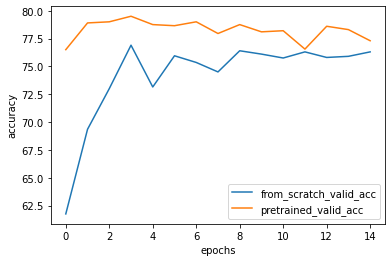

In [ ]:
### Visualize the accuracy
# ===========================
import matplotlib.pyplot as plt

X = range(epochs)
plt.plot(X, from_scratch_valid_acc, label='from_scratch_valid_acc')
plt.plot(X, pretrained_valid_acc, label="pretrained_valid_acc")
plt.xlabel("epochs"); 
plt.ylabel("accuracy")

plt.legend()
plt.show()
# ===========================